In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import random

# -----------------------------
# User settings
# -----------------------------
patient_id = 3                     # change to the patient you want (1..12)
patient_folder = f"Patient{patient_id}"
cluster_pattern = "cluster{}.csv"  # cluster1.csv ... cluster15.csv
n_clusters_expected = 15

n_samples = 6000
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# timepoint names (must match columns order in CSVs)
timepoint_names = [
    'Before Surgery', '5 Minutes', '30 Minutes', '60 Minutes',
    '120 Minutes', '1 Day', '2 Days', '3 Days',
    '4 Days', '10 Days', '3 Months', '6 Months', '1 Year'
]

T = len(timepoint_names)

# -----------------------------
# Load all clusters into memory
# -----------------------------
clusters = []

for c in range(1, n_clusters_expected + 1):
    fname = os.path.join(patient_folder, cluster_pattern.format(c))
    if not os.path.exists(fname):
        raise FileNotFoundError(f"Missing: {fname}")

    df = pd.read_csv(fname, header=None)
    clusters.append(df)

print(f"Loaded {len(clusters)} clusters.")

# -----------------------------
# Utility to fix strings like '[[1.02]]' -> 1.02
# -----------------------------
def clean_float(x):
    x = str(x).replace("[", "").replace("]", "")
    return float(x)

# -----------------------------
# Function: sample 1 random gene per cluster
# -----------------------------
def sample_one_panel():
    gene_matrix = np.zeros((n_clusters_expected, T))
    gene_names = []

    for ci, df in enumerate(clusters):
        row_idx = random.randrange(df.shape[0])
        row = df.iloc[row_idx, :].values
        gene_names.append(str(row[0]))

        expr_vals = np.array([clean_float(v) for v in row[1:1+T]], dtype=float)
        gene_matrix[ci, :] = expr_vals

    return gene_matrix, gene_names

# -----------------------------
# Generate N samples
# -----------------------------
all_samples = np.zeros((n_samples, n_clusters_expected, T))

gene_name_list = []  # keep names if needed

for i in range(n_samples):
    mat, names = sample_one_panel()
    all_samples[i] = mat
    gene_name_list.append(names)

print("Generated sample matrix shape:", all_samples.shape)
# shape → (1000, 15, 13)

# -----------------------------
# Train/test split (80/20)
# -----------------------------
sample_indices = np.arange(n_samples)
train_idx, test_idx = train_test_split(sample_indices, test_size=0.2, random_state=random_seed)

print("Train samples:", len(train_idx))
print("Test samples :", len(test_idx))


Loaded 15 clusters.
Generated sample matrix shape: (6000, 15, 13)
Train samples: 4800
Test samples : 1200


In [2]:
# Prepare expression rows
expr_rows = []

for c in range(n_clusters_expected):
    # all_samples[:, c, :] → shape (n_samples, T)
    # transpose to (T, n_samples) to match Drosophila row-per-timepoint
    expr_block = all_samples[:, c, :].T  # shape: (T, n_samples)
    expr_rows.extend(expr_block)          # append T rows per cluster

# Convert to DataFrame
expr_df = pd.DataFrame(expr_rows)

# Add column names for samples
expr_df.columns = [f"Sample_{i+1}" for i in range(n_samples)]

# Save CSV
csv_fname = f"liver_data_for_dsrn_patient{patient_id}.csv"
expr_df.to_csv(csv_fname, index=False)
print("Saved liver DSRN CSV:", expr_df.shape)


Saved liver DSRN CSV: (195, 6000)


In [3]:
#============================================================
# DSRN for Liver Regeneration Gene Expression Prediction
# Predict next timepoint from previous timepoint
#============================================================

# =====================================================
# LOAD Data
# =====================================================
file = f"liver_data_for_dsrn_patient{patient_id}.csv"
df = pd.read_csv(file)

print("Loaded:", df.shape)

# -----------------------------------------------------
# Extract timepoint rows only
# First 4 rows = coordinates
# Then 6 rows per gene
# -----------------------------------------------------
expr = df.iloc[:, :].values       # shape (13*num_genes/clusters, num_samples)

num_cells = expr.shape[1]
num_genes = expr.shape[0] // T

print("Genes/clusters:", num_genes)
print("Samples:", num_cells)

# =====================================================
# Define transitions of interest
# =====================================================
transitions_of_interest = [
    ('5 Minutes', '1 Day'),
    ('1 Day', '3 Months')
]

# Map timepoint names to indices
timepoint_to_idx = {name: i for i, name in enumerate(timepoint_names)}

# =====================================================
# FORM INPUT → OUTPUT PAIRS FOR SELECTED TRANSITIONS
# =====================================================
X = []
Y = []

for g in range(num_genes):
    block = expr[g*T:(g+1)*T, :]    # shape (T, num_cells)

    for from_name, to_name in transitions_of_interest:
        t_from = timepoint_to_idx[from_name]
        t_to   = timepoint_to_idx[to_name]

        X.append(block[t_from, :])
        Y.append(block[t_to, :])

X = np.array(X)  # (num_genes * num_transitions, num_cells)
Y = np.array(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

# =====================================================
# TRAIN / TEST SPLIT — 80% cells train, 20% test
# =====================================================
cells = np.arange(num_cells)
train_idx, test_idx = train_test_split(cells, test_size=0.2, random_state=42)

print("Train cells:", len(train_idx))
print("Test cells:", len(test_idx))

# =====================================================
# NORMALIZE
# =====================================================
scaler_in = StandardScaler()
scaler_out = StandardScaler()

X_norm = scaler_in.fit_transform(X.T).T       # shape (samples, cells)
Y_norm = scaler_out.fit_transform(Y.T).T       # same

M = X_norm.shape[0]   # input dimension
P = Y_norm.shape[0]   # output
D = X_norm.shape[1]   # number of samples (cells)

print("Input dim:", M, "Output dim:", P)


# =====================================================
# RESERVOIR PARAMETERS (same as Lorenz DSRN)
# =====================================================

N = 100   # reservoirs
param_range_reservoir = [(9.9, 10.1), (27.9, 28.1), (2.65, 2.70)]
param_range_R = [(-1, 1), (-1, 1), (-1, 1)]
t_initial, t_final = 0, 4
num_eval_points = 200

# Random reservoir parameters
reservoir_params = np.array([
    [np.random.uniform(low, high) for low, high in param_range_reservoir] +
    [np.random.uniform(1, 8)]
    for _ in range(N)
])

# Random input matrix
R = np.zeros((3*N, M))
for i in range(3*N):
    R[i, :] = np.random.uniform(-1,1,size=(M,))

print("R:", R.shape)

# =====================================================
# LORENZ SYSTEM FOR RESERVOIR
# =====================================================
def lorenz_system(t, X, params):
    X = X.reshape(N, 3)
    dxdt = params[:,0] * (X[:,1] - X[:,0]) / params[:,3]
    dydt = (X[:,0]*(params[:,1]-X[:,2]) - X[:,1]) / params[:,3]
    dzdt = (X[:,0]*X[:,1] - params[:,2]*X[:,2]) / params[:,3]
    return np.stack([dxdt, dydt, dzdt], axis=1).flatten()

# =====================================================
# RESERVOIR COMPUTATION
# =====================================================
phi = np.zeros((3*N, D))

for i in range(D):
    inp = np.dot(R, X_norm[:, i])
    sol = solve_ivp(
        lorenz_system, (t_initial, t_final), inp,
        t_eval=[t_final], args=(reservoir_params,),
        rtol=1e-6, atol=1e-9
    )
    phi[:, i] = sol.y[:, -1]

print("Reservoir state shape:", phi.shape)

# TRAIN ON TRAIN CELLS ONLY
phi_train = phi[:, train_idx].T
phi_test  = phi[:, test_idx].T

Y_train = Y_norm[:, train_idx].T
Y_test  = Y_norm[:, test_idx].T

# =====================================================
# LEAST SQUARES READOUT
# =====================================================
S_T, residuals, rank, svals = np.linalg.lstsq(phi_train, Y_train, rcond=None)
S = S_T.T   # (P, 3N)

# =====================================================
# PREDICT
# =====================================================
pred_train_norm = S @ phi[:, train_idx]
pred_test_norm  = S @ phi[:, test_idx]

pred_train = scaler_out.inverse_transform(pred_train_norm.T).T
pred_test  = scaler_out.inverse_transform(pred_test_norm.T).T

Y_train_true = Y[:, train_idx].astype(float)
Y_test_true  = Y[:, test_idx].astype(float)

# =====================================================
# Ensure prediction and ground truth are float
# =====================================================

pred_train = np.array(pred_train, dtype=float)
pred_test  = np.array(pred_test, dtype=float)

Y_train_true = np.array(Y_train_true, dtype=float)
Y_test_true  = np.array(Y_test_true, dtype=float)

# =====================================================
# METRICS
# =====================================================
mse_train = np.mean((pred_train - Y_train_true)**2)
mse_test  = np.mean((pred_test - Y_test_true)**2)

corr_train = pearsonr(pred_train.flatten(), Y_train_true.flatten())[0]
corr_test  = pearsonr(pred_test.flatten(),  Y_test_true.flatten())[0]

print("\n===========================")
print("TRAIN MSE:", mse_train)
print("TEST  MSE:", mse_test)
print("TRAIN Corr:", corr_train)
print("TEST  Corr:", corr_test)
print("===========================\n")


Loaded: (195, 6000)
Genes/clusters: 15
Samples: 6000
X shape: (30, 6000)
Y shape: (30, 6000)
Train cells: 4800
Test cells: 1200
Input dim: 30 Output dim: 30
R: (300, 30)
Reservoir state shape: (300, 6000)

TRAIN MSE: 0.05682803790687576
TEST  MSE: 0.0679793386706887
TRAIN Corr: 0.8976499927069085
TEST  Corr: 0.8792460425466095



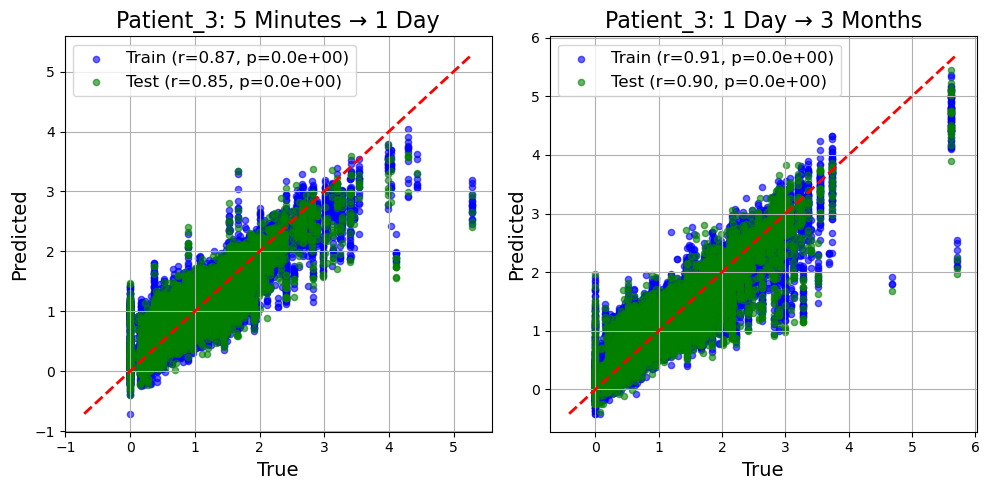

In [4]:
# =====================================================
# Plot only transitions of interest with Pearson r and p-values
# =====================================================

patient_name = f"Patient_{patient_id}"   # <-- set this to your patient variable

num_transitions = len(transitions_of_interest)
fig, axes = plt.subplots(1, num_transitions, figsize=(5*num_transitions, 5))
if num_transitions == 1:
    axes = [axes]  # make it iterable if only 1 transition

for t_idx, (from_name, to_name) in enumerate(transitions_of_interest):
    ax = axes[t_idx]

    # Extract corresponding rows in X/Y
    rows_idx = np.arange(num_genes) + t_idx * num_genes
    true_train = Y_train_true[rows_idx, :]
    true_test  = Y_test_true[rows_idx, :]

    pred_train_sub = pred_train[rows_idx, :]
    pred_test_sub  = pred_test[rows_idx, :]

    # ---- Compute correlation and p-values ----
    corr_train, p_train = pearsonr(true_train.flatten(), pred_train_sub.flatten())
    corr_test, p_test   = pearsonr(true_test.flatten(), pred_test_sub.flatten())

    # ---- Scatter plot ----
    ax.scatter(true_train.flatten(), pred_train_sub.flatten(),
               color='blue', alpha=0.6, s=20,
               label=f"Train (r={corr_train:.2f}, p={p_train:.1e})")
    ax.scatter(true_test.flatten(), pred_test_sub.flatten(),
               color='green', alpha=0.6, s=20,
               label=f"Test (r={corr_test:.2f}, p={p_test:.1e})")

    # ---- Identity line ----
    mn = min(true_train.min(), true_test.min(),
             pred_train_sub.min(), pred_test_sub.min())
    mx = max(true_train.max(), true_test.max(),
             pred_train_sub.max(), pred_test_sub.max())
    ax.plot([mn, mx], [mn, mx], 'r--', linewidth=2)

    # ---- Title with patient name ----
    ax.set_title(f"{patient_name}: {from_name} → {to_name}", fontsize=16)

    ax.set_xlabel("True", fontsize=14)
    ax.set_ylabel("Predicted", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)

plt.tight_layout()

# ---- Save Figure ----
save_path = f"liver_transitions_{patient_name}.jpeg"
plt.savefig(save_path, format = 'jpeg', dpi=650, bbox_inches='tight')

plt.show()
